In [78]:
import numpy as np
import json
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


cm = 1/2.54
DPI = 600


DATA_LOCATION =  '/Users/brendan/Documents/projects/hotspot/go/data/'
IMAGE_LOCATION = '/Users/brendan/Documents/projects/hotspot/writeup/images/'
D1_DATA = "simulation,D=1,T=1000.json"
D8_DATA = "simulation,D=8,T=1000.json"
DIFEQ_DATA = "difeq,D=1,T=1.json"

COLUMN_NAMES = {
    "RunSets.Parameters.R0": "$R_0$",
    "HotspotFraction": "Hotspot fraction",
    "RiskVariance": "Risk tolerance variance",
    # make sure RiskMean is made categorical first
    "RiskMean": "Risk tolerance mean",
    "MaxIDiff": "Peak size difference",
    "FinalRDiff": "Extent difference",
    "OutbreakProbability": "Outbreak probability",
}


EXTINCTION_CUTOFF = 50
TRIALS = 1000
N = 1000
SAVE_FIGS = False

## Plotting setup
blue_red_purple = ["#466be3","#be89f0", "#f74a64"]
blue_red_purple_corrected = ["#466be3","#bb5ea3", "#f74a64"]
brp3 = ["#67bdff", "#be89f0", "#d32349"]
brp4 = ['#006eff', '#cf78f5', '#ff5759']
brp5 = ["#006eff", "#7640f5", "#f74a75"] # Currently I like this the best!


colors = brp5
sns.set_style("ticks")
sns.set_palette(colors)
sns.color_palette()
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

In [58]:
# Loads the data

def load_data(file_name):

    with open(DATA_LOCATION + file_name) as file:
            json_file = json.load(file, parse_float=lambda f: round(float(f), 2))
            
    data = pd.json_normalize(
        json_file,
        record_path=["RunSets", "Runs"],
        meta=[
            "RiskMean",
            "RiskVariance",
            "HotspotFraction",
            ["RunSets", "Parameters", "R0"],
            ["RunSets", "Parameters", "RunType"]
        ],
    )
    return data

data = load_data("simulation,D=1,T=1000.json")


In [59]:
# Process data
def process_data(data):
    
    data["OutbreakProbability"] = 1.0 - 1.0*(data["FinalR"] <= EXTINCTION_CUTOFF)
    data["RiskMean"] = pd.Categorical(data["RiskMean"])
    
    ## Uses np.tile to replicate the control series
    def tile(column):
        num_ppf = len(data["HotspotFraction"].unique())
        return pd.Series(np.tile(data[data["HotspotFraction"] == 0][column], num_ppf))
    
    data["MaxIControl"] = tile("MaxI")
    data["FinalRControl"] =  tile("FinalR")
    
    data["FinalRDiff"] = data["FinalR"] - data["FinalRControl"]
    data["MaxIDiff"] = data["MaxI"] - data["MaxIControl"]
    data = data[data["HotspotFraction"] != 0]
    
    data = data.rename(columns=COLUMN_NAMES)
    return data

data = process_data(data)

In [60]:
data

,FinalR,MaxI,Risk tolerance mean,Risk tolerance variance,Hotspot fraction,$R_0$,RunSets.Parameters.RunType,Outbreak probability,MaxIControl,FinalRControl,Extent difference,Peak size difference
729000,1,1,0.50,low,0.25,0,,0.0,1,1,0,0
729001,1,1,0.50,low,0.25,0,,0.0,1,1,0,0
729002,1,1,0.50,low,0.25,0,,0.0,1,1,0,0
729003,1,1,0.50,low,0.25,0,,0.0,1,1,0,0
729004,1,1,0.50,low,0.25,0,,0.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2915995,868,255,0.12,high,0.75,8.0,,1.0,601,999,-131,-346
2915996,868,252,0.12,high,0.75,8.0,,1.0,563,1000,-132,-311
2915997,847,250,0.12,high,0.75,8.0,,1.0,567,999,-152,-317
2915998,862,271,0.12,high,0.75,8.0,,1.0,483,999,-137,-212


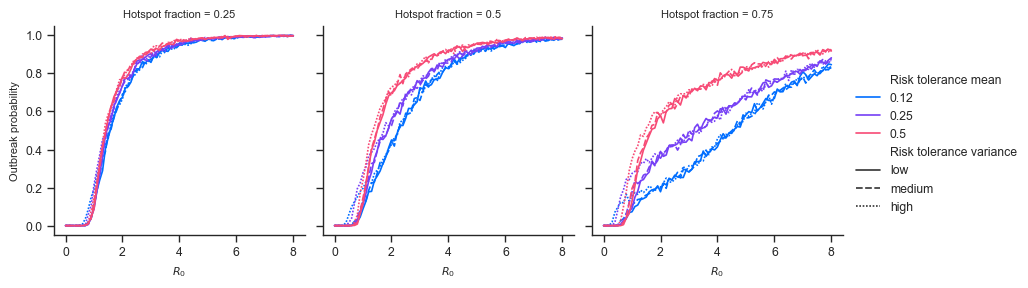

In [77]:
def plot_2_A(data):
    rp = sns.relplot(
        data=data,
        kind="line",
        errorbar=None,
        n_boot=None,
        y="Outbreak probability",
        x="$R_0$",
        col="Hotspot fraction",
        style="Risk tolerance variance",
        hue="Risk tolerance mean",
        height=11*cm*2/3,
        aspect=1.0,
    )

    # for ax in rp.axes[0]:
    #     # sns.lineplot(
    #     #     data=control,
    #     #     y="Outbreak Probability",
    #     #     x="R0",
    #     #     color="black",
    #     #     ax=ax,
    #     #     legend=None,
    #     #     alpha=0.7,
    #     # )
    #     sns.lineplot(
    #         x=X,
    #         y=homogeneous_extinction,
    #         ax=ax,
    #         color="green",
    #         alpha=0.7,
    #         legend=None,
    #     )
    if SAVE_FIGS:
        rp.savefig(IMAGE_LOCATION + "figure2A.png", dpi=DPI)
    else:
        plt.show()
        
plot_2_A(data)

In [45]:





def melt():


    melt = pd.melt(Sim[Sim["Extinction Probability"] == 0], id_vars=['R0', 'Hot Spot Fraction', 'Risk Distribution Mean', 'Risk Distribution Variance'], 
                         value_vars=['Extent Difference', 'Peak Size Difference'],
                         var_name="variable", value_name="value")

    outcome_plot = sns.relplot(
        data=melt,
        row="variable",
        y="value",
        x="R0",
        kind="line",
        col="Hot Spot Fraction",
        hue="Risk Distribution Mean",
        style="Risk Distribution Variance",
        facet_kws={"sharey":"row"})



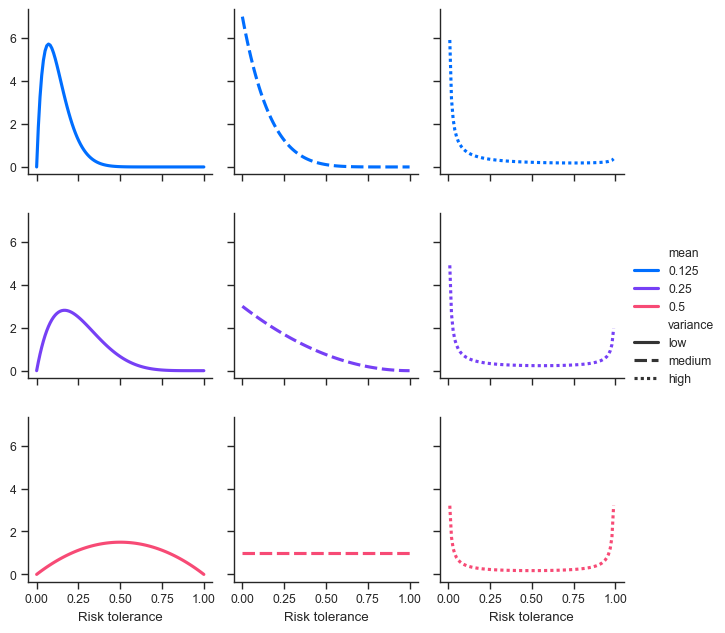

In [98]:
def plot_1_B():

    x = np.linspace(0, 1, 100)
    bases = [(1, 7, 0.125), (1, 3, 0.25),  (1, 1, 0.5)]
    factors = [(2, "low"), (1, "medium"), (0.1, "high")]

    LINEWIDTH = 2.25

    data = {
        "variance": [],
        "RiskMean": [],
        "ρ": [],
        "density": [],
    }

    for i, (a, b, base) in enumerate(bases):
        for j, (f, factor) in enumerate(factors):
            


            g = stats.beta(f*a, f*b)
            y = g.pdf(x)
            data["variance"].extend([factor]*len(y))
            data["RiskMean"].extend([base]*len(y))
            data["ρ"].extend(x)
            data["density"].extend(y)

    distributions = pd.DataFrame(data)
    distributions["mean"] = pd.Categorical(distributions["RiskMean"])
            

    #sns.set_context("paper")
    rel = sns.relplot(data=distributions,
                kind="line",
                linewidth=LINEWIDTH,
                x="ρ", y="density", row="mean",
                height=2.2,
                col="variance",
                hue="mean",
                style="variance")
    rel.set_titles("")
    rel.set(xlabel="Risk tolerance")
    rel.set(ylabel=None)
    if SAVE_FIGS:
        rel.savefig(IMAGE_LOCATION + "risk_distributions.png", dpi=DPI)
    else:
        plt.show()

plot_1_B()

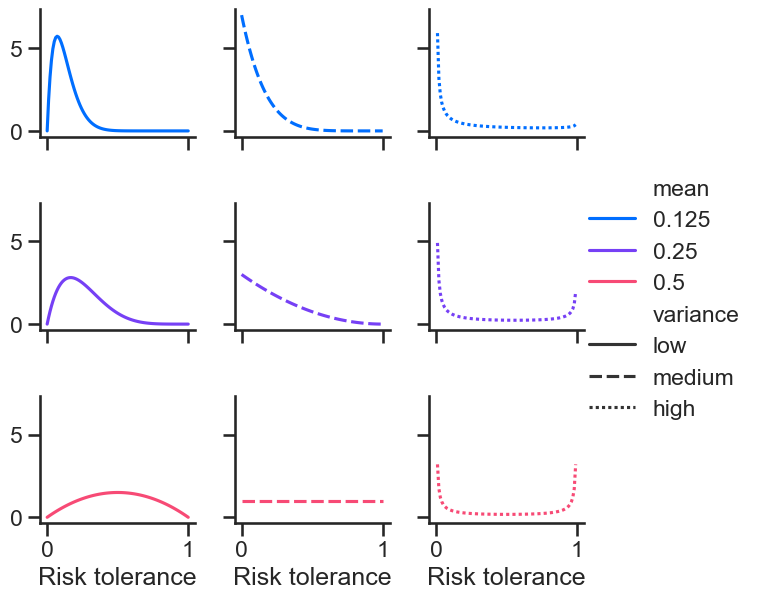

In [89]:
plot_1_B()

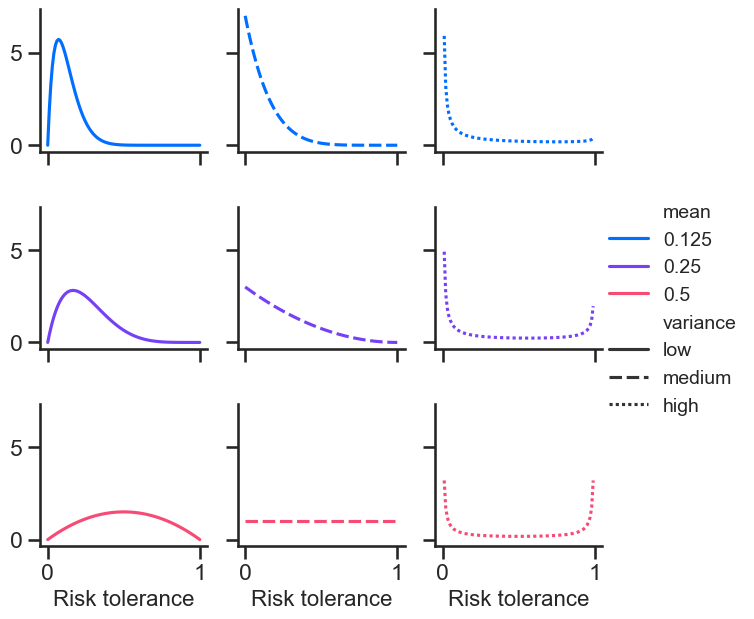

In [104]:
sns.set_context("paper", rc={
     'font.size': 12.0,
     'axes.labelsize': 16.0,
     'axes.titlesize': 18.0,
     'xtick.labelsize': 16.5,
     'ytick.labelsize': 16.5,
     'legend.fontsize': 14.0,
     'legend.title_fontsize': 18.0,
     'axes.linewidth': 1.875,
     'grid.linewidth': 1.5,
     #'lines.markersize': 9.0,
     #'patch.linewidth': 1.5,


    
    'lines.linewidth': 2.25,   
     'axes.linewidth': 1.875,
    'xtick.major.width': 1.875,
     'ytick.major.width': 1.875,
     'xtick.minor.width': 1.5,
     'ytick.minor.width': 1.5,
     'xtick.major.size': 9.0,
     'ytick.major.size': 9.0,
     'xtick.minor.size': 6.0,
     'ytick.minor.size': 6.0
})
sns.plotting_context()
plot_1_B()

In [95]:
sns.set_context("talk")
sns.plotting_context()

{'font.size': 18.0,
 'axes.labelsize': 18.0,
 'axes.titlesize': 18.0,
 'xtick.labelsize': 16.5,
 'ytick.labelsize': 16.5,
 'legend.fontsize': 16.5,
 'legend.title_fontsize': 18.0,
 'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0}